In [164]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

In [77]:
data = pd.read_csv('mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [78]:
px.pie(data,names='type',title='Distribution of personality types',hole=0.3)

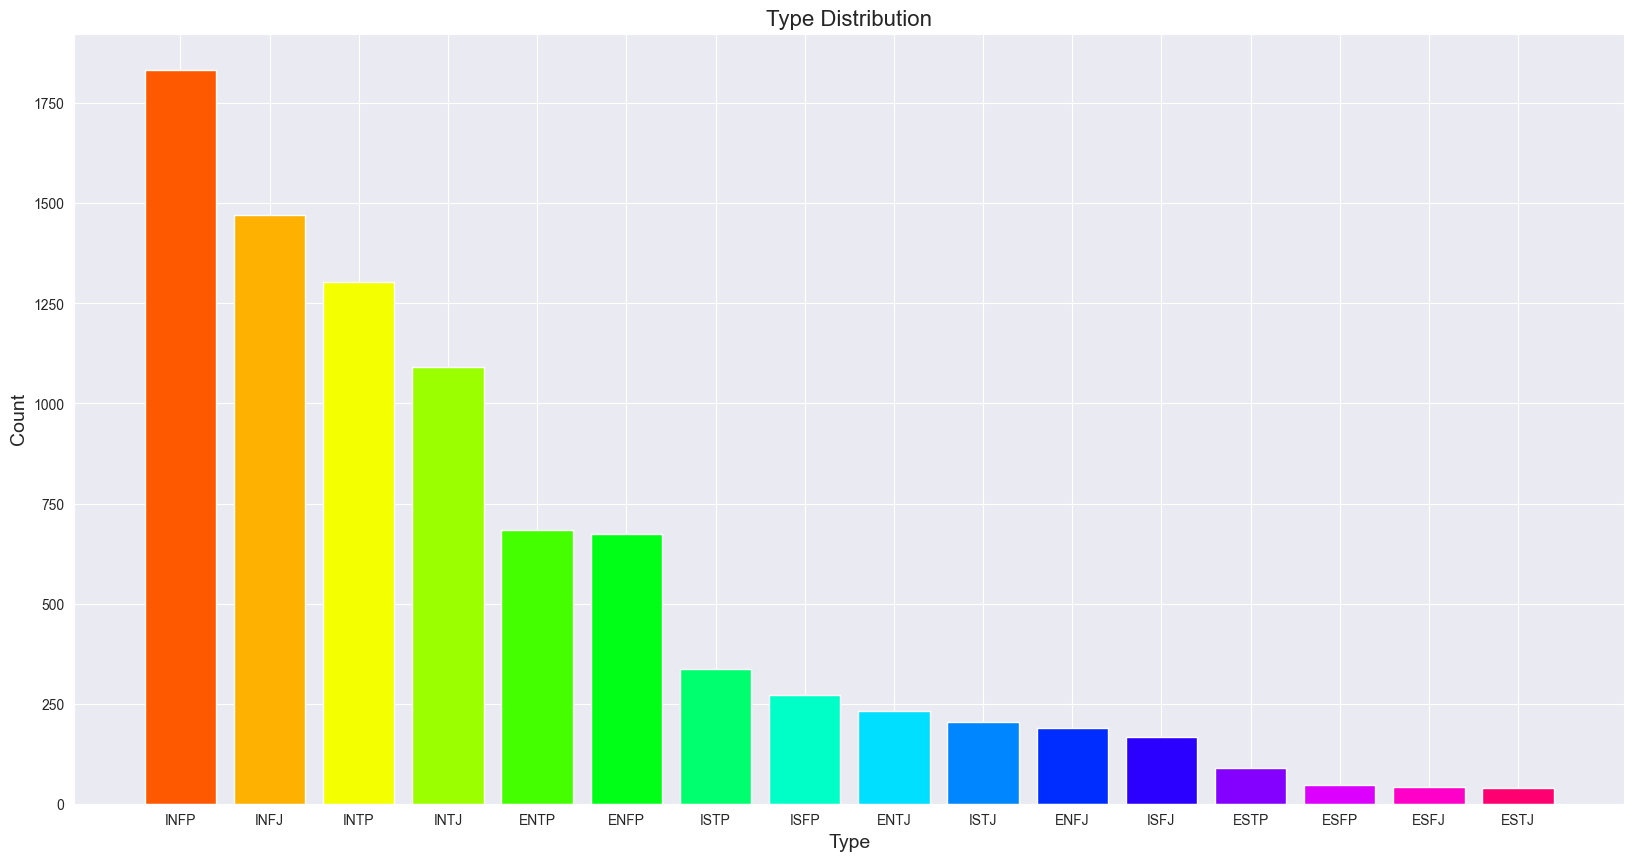

In [79]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette("hsv", len(data["type"].unique()))

plt.bar(data["type"].value_counts().reset_index()['type'], data["type"].value_counts().reset_index()['count'], color=colors)

plt.xlabel('Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Type Distribution', fontsize=16)

plt.show()

In [80]:
data['type'] = data['type'].replace(['INFP', 'ESFJ'], 'Friendly').replace(['INTP', 'ESTP','ENFP'], 'Brave') .replace(['INFJ', 'ISFJ','ESFP' ], 'Helpful') .replace(['INTJ', 'ENTJ','ISFP','ESTJ'], 'Logical') .replace(['ENTP', 'ENFJ', 'ISTJ','ISTP'], 'Warrior') 

In [81]:
data['type'].value_counts()

type
Brave       2068
Friendly    1874
Helpful     1684
Logical     1632
Warrior     1417
Name: count, dtype: int64

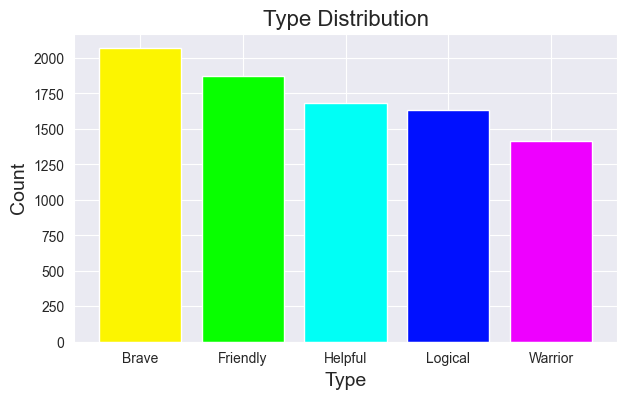

In [82]:
plt.figure(figsize=(7, 4))
colors = sns.color_palette("hsv", len(data["type"].unique()))

plt.bar(data["type"].value_counts().reset_index()['type'], data["type"].value_counts().reset_index()['count'], color=colors)

plt.xlabel('Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Type Distribution', fontsize=16)

plt.show()

## Without Preprocessing

In [109]:
def data_length(data):
    data_length=[]
    for sentence in tqdm(data):
        data_length.append(len(sentence.split()))
    return data_length

In [110]:
X = data['posts'] # features

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['type'] ) # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
train_length = data_length(X_train)

  0%|          | 0/6940 [00:00<?, ?it/s]

In [106]:
test_length=data_length(X_test)

  0%|          | 0/1735 [00:00<?, ?it/s]

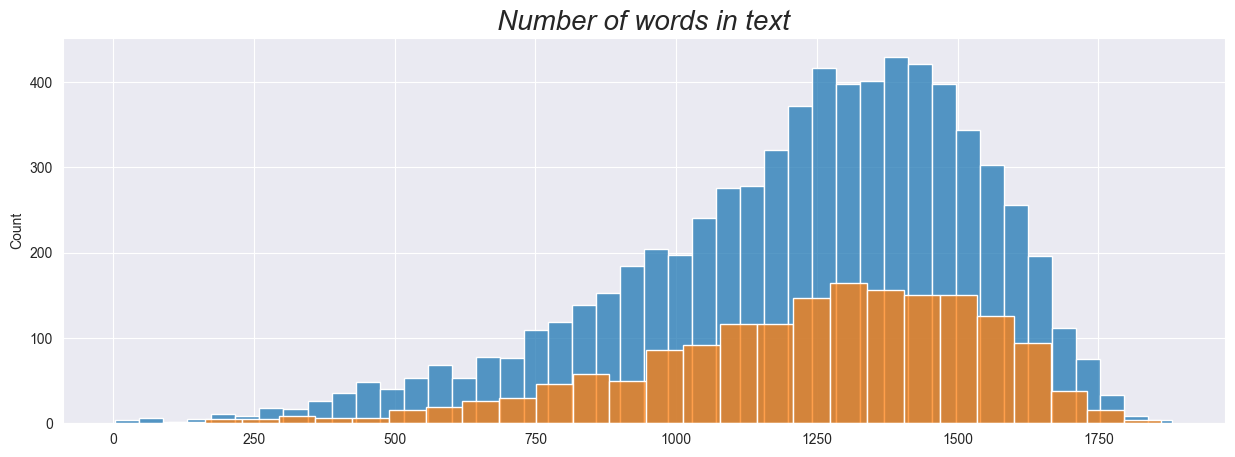

In [12]:
plt.figure(figsize=(15,5))
sns.histplot(train_length,label='train data word length')
sns.histplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(max_features=5000,stop_words='english')
vectorizer.fit(X_train)

TfidfVectorizer(max_features=5000, stop_words='english')

In [112]:
train_post = vectorizer.transform(X_train).toarray()
test_post = vectorizer.transform(X_test).toarray()

In [14]:
target_encoder = LabelEncoder()
train_target = target_encoder.fit_transform(y_train)
test_target = target_encoder.fit_transform(y_test)

In [113]:
model_log = LogisticRegression(max_iter=1000)
model_log.fit(train_post,y_train)

LogisticRegression(max_iter=1000)

### For train data

In [115]:
print(classification_report(y_train,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(5)])))

              precision    recall  f1-score   support

       Brave       0.82      0.85      0.84      1635
    Friendly       0.84      0.90      0.87      1497
     Helpful       0.86      0.84      0.85      1343
     Logical       0.85      0.83      0.84      1335
     Warrior       0.86      0.79      0.82      1130

    accuracy                           0.84      6940
   macro avg       0.85      0.84      0.84      6940
weighted avg       0.85      0.84      0.84      6940



#### For test data

In [117]:
print(classification_report(y_test,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(5)])))

              precision    recall  f1-score   support

       Brave       0.69      0.76      0.72       433
    Friendly       0.71      0.80      0.75       377
     Helpful       0.71      0.63      0.67       341
     Logical       0.65      0.68      0.67       297
     Warrior       0.71      0.54      0.62       287

    accuracy                           0.69      1735
   macro avg       0.70      0.68      0.69      1735
weighted avg       0.70      0.69      0.69      1735



## Preprocessing

In [146]:
data_clean = pd.DataFrame(data[["type", "posts"]])

In [147]:
import re

def clean_url(str_text_raw):
    """This function eliminate a string URL in a given text"""
    str_text = re.sub("url_\S+", "", str_text_raw)
    str_text = re.sub("email_\S+", "", str_text)
    str_text = re.sub("phone_\S+", "", str_text)
    return(re.sub("http[s]?://\S+", "", str_text))
    
def clean_punctuation(str_text_raw):
    """This function replace some of the troublemaker puntuation elements in a given text"""
    str_text = re.sub("[$\(\)/|{|\}#~\[\]^#;:!?¿_,.']", " ", str_text_raw)
    return(re.sub(r'\.{3}', " ", str_text))

def clean_unicode(str_text_raw):
    """This function eliminate non-unicode text"""
    str_text = re.sub("&amp;", "", str_text_raw)
    return(re.sub(r"[^\x00-\x7F]+"," ", str_text))
                      
def clean_dot_words(str_text_raw):
    """This function replace dots between words"""
    return(re.sub(r"(\w+)\.+(\w+)", r"\1 \2",str_text_raw))

def clean_text(str_text_raw):
    """This function sets the text to lowercase and applies previous cleaning functions """
    str_text = str_text_raw.lower()
    str_text = clean_dot_words(clean_punctuation(clean_unicode(clean_url(str_text))))
    return(str_text)

In [148]:
for c in data_clean.columns:
    data_clean[c] = data_clean[c].apply(lambda row: clean_text(row))
data_clean['posts'] = data_clean['posts'].apply(lambda x: " ".join(x.strip() for x in x.split()))
data_clean.head()

type  \
0  helpful   
1  warrior   
2    brave   
3  logical   
4  logical   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [149]:
#Remove multiple letter repating words like "aaa", "oo", "llll"
data_clean["posts"] = data_clean["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x))
data_clean.head()

type  \
0  helpful   
1  warrior   
2    brave   
3  logical   
4  logical   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [152]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)


def clean_text(text):
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text)
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE)
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE)
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub("\'s", " ",
                  text)  # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)  # replace whats by what is and ignore case
    text = re.sub("\'ve", " have ", text)  # replace 've by have
    text = re.sub("can't", "can not", text)  # replace can't by can not
    text = re.sub("n't", " not ", text)  # replace n't by not
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)  # replace i'm by i am and ignore case
    text = re.sub("\'re", " are ", text)  # replace 're by are
    text = re.sub("\'d", " would ", text)  # replace 'd by would
    text = re.sub("\'ll", " will ", text)  # replace 'll by will
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)  # replace e.g. by eg and ignore case
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)  # replace b.g. by bg and ignore case
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    return text


def clean_punctuation(str_text_raw):
    str_text_raw = str_text_raw.lower()
    str_text = re.sub("[$\(\)/|{|\}#~\[\]^#;:!?%¿_,.'\"']", " ", str_text_raw)
    return (re.sub(r'\.{3}', " ", str_text))

from nltk.corpus import stopwords
# Load stop words
stop_words = set(stopwords.words('english'))


def remove_stop_words(text):
    cleaned_text = " ".join([word for word in text.split() if word not in stop_words])
    return cleaned_text


def remove_short_words(text):
    pattern = r'\b\w{1,2}\b'
    return re.sub(pattern, '', text)


def stemming(words):
    ps = PorterStemmer()
    stem = []
    for w in words:
        stem.append(ps.stem(w))
    return stem


def tokenizer(words):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(words)
    return words


def lemmatization(words):
    wnetlemmatizer = WordNetLemmatizer()

    lemmatized = []
    for w in words:
        lemmatized.append(wnetlemmatizer.lemmatize(w))
    return lemmatized

def vectorizer(list_of_docs,model):
    feature =[] 
    for rew in list_of_docs: # iterating over reviews
        zero_vector = np.zeros(model.vector_size) 
        vectors =[] 
        for word in rew : # iterating over all words in a review
            if word in model:
                try :
                    vectors.append(model[word]) 
                except KeyError:
                    continue
        if vectors: 
            vectors = np.asarray(vectors) # converting multiple arrays into a single array
            avg_vec = vectors.mean(axis=0) 
            feature.append(avg_vec) 
        else :
            feature.append(zero_vector)
    return feature

def text_preprocessing(text):
    text = remove_numbers(text)
    text = clean_text(text)
    text = clean_punctuation(text)
    text = " ".join(x.strip() for x in text.split())
    text = remove_stop_words(text)
    text =  remove_short_words(text)
    text = " ".join(x.strip() for x in text.split())
    text = tokenizer(text)
    text = stemming(text)
    text = lemmatization(text)
    return text

In [153]:
data_clean['posts'] = data_clean['posts'].apply(text_preprocessing)

In [154]:
data_clean['posts'] = data_clean['posts'].apply(lambda x: ' '.join(x))
data_clean['posts'] = data_clean['posts'].str.replace(r'[^\w\s]', ' ').str.replace(r'\s+', ' ', regex=True)
data_clean.head()

,type,posts
0,helpful,intj moment sportscent top ten play prank life chang experi life repeat today may perc experi immers last thing infj friend post facebook commit suicid next day rest peac enfj sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth welcom stuff game set match prozac wellbrutin least thirti minut move leg mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear enfp favorit video game grow current favorit video game cool appear late sad someon everyon wait thought confid good thing cherish time solitud revel within inner world wherea time workin enjoy time worri peopl alway around entp ladi complimentari person well hey main social outlet xbox live convers even verbal fatigu quickli realli dig part thread requir get high backyard roast eat marshmellow backyard convers someth intellectu follow massag kiss mani sentenc could think ban watch movi corner dunc ban health class clearli taught noth peer pressur ban whole host reason two babi deer left right munch beetl middl use blood two caveman diari today latest happen design cave diari wall see pokemon world infj societi everyon becom optimist artist artist draw idea count form someth like signatur welcom robot rank person down self esteem cuz avid signatur artist like proud ban take room bed gotta learn share roach much thunder grumbl kind storm yep ahh old high school music heard age fail public speak class year ago sort learn could better posit big part failur overload like person mental confirm intj way denver area start new life
1,warrior,find lack post alarm sex bore posit often exampl girlfriend current environ creativ use cowgirl missionari enough give new mean game theori hello entp grin take convers flirt acknowledg presenc return word smooth wordplay cheeki grin lack balanc hand eye coordin real test score internet test funni score higher like former respons thread mention believ test banish know entp vanish site year half return find peopl still comment post like idea thought know entp think thing sometim old sherlock holm quot perhap man special knowledg special power like rather encourag seek complex cheshirewolf tumblr com post realli never thought real function judg use use domin emot rare also use due strength know though ingeni say realli want tri see happen play first person shooter back drive around want see look rock paper one best make lol guy lucki realli high tumblr system hear new first person shooter game rock hell soundtrack auto sound equip shake heaven manag put coupl way connect thing domin awar environ domin exampl shawn spencer patrick jane entp well charli first admit get jealou like chalk heart mix domin like notic like known upload clip mic away mouth hear anyth ninja assassin style splatter tik tok realli great song long mental block singer love beat make bounc drop vswck mic realli close mouth smokin ace assassin ball play background sociabl extrovert extrovert sociabl sherlock movi entp normal play extj book estj said movi look good except call sherlock holm never fear kiss guy kiss anim noth vanish person tast like guy kiss know one sound pretti much like area go right tri figur way want take life want mani thing biggest problem know oper impress femal never look boxi okay help gay friend time one develop littl crush get red describ live worst nightmar trap one place one one around dull wood serial killer would perfect place sadli tbh bias sound like shadow infp think mayb hurt turn estj tell typic infp trait left check list sorri seem came bad time alreadi reach quota infj howev femal like femal make deal kick one antp lean toward easi entp intp identifi also imagin entp interrog would littl bit like jack except mechan rig shock treatment equip aband

In [155]:
X = data_clean['posts'] # features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

final_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
final_vectorizer.fit(X_train)
train_post = final_vectorizer.transform(X_train)
test_post = final_vectorizer.transform(X_test)

In [157]:
model_log = LogisticRegression(max_iter=1000)
model_log.fit(train_post,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
print(classification_report(y_train,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(5)])))

In [158]:
print(classification_report(y_test,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(5)])))

              precision    recall  f1-score   support

       Brave       0.67      0.76      0.71       433
    Friendly       0.73      0.79      0.76       377
     Helpful       0.69      0.63      0.66       341
     Logical       0.64      0.65      0.64       297
     Warrior       0.67      0.54      0.60       287

    accuracy                           0.68      1735
   macro avg       0.68      0.67      0.67      1735
weighted avg       0.68      0.68      0.68      1735



In [161]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_post,y_train)

RandomForestClassifier(random_state=42)

In [162]:
print(classification_report(y_test,rf_model.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(5)])))

              precision    recall  f1-score   support

       Brave       0.52      0.75      0.62       433
    Friendly       0.60      0.75      0.67       377
     Helpful       0.60      0.50      0.54       341
     Logical       0.58      0.47      0.52       297
     Warrior       0.67      0.27      0.39       287

    accuracy                           0.57      1735
   macro avg       0.59      0.55      0.55      1735
weighted avg       0.59      0.57      0.56      1735



In [167]:
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=15, learning_rate=0.1, colsample_bytree=0.8, gamma=0,
                              reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)
xgb_model.fit(train_post,y_train)

C:\Users\melnur\AppData\Local\anaconda3\envs\buckai\lib\site-packages\xgboost\core.py:160: UserWarning:

[11:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=15,
              n_jobs=None, num_parallel_tree=None, ...)

In [168]:
print(classification_report(y_test,xgb_model.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(5)])))

              precision    recall  f1-score   support

       Brave       0.63      0.75      0.68       433
    Friendly       0.70      0.73      0.72       377
     Helpful       0.68      0.64      0.66       341
     Logical       0.67      0.63      0.65       297
     Warrior       0.69      0.54      0.60       287

    accuracy                           0.67      1735
   macro avg       0.67      0.66      0.66      1735
weighted avg       0.67      0.67      0.67      1735



In [171]:
tree_model =DecisionTreeClassifier(max_depth=1000)
tree_model.fit(train_post,y_train)

DecisionTreeClassifier(max_depth=1000)

In [172]:
print(classification_report(y_test,tree_model.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(5)])))

              precision    recall  f1-score   support

       Brave       0.53      0.53      0.53       433
    Friendly       0.57      0.57      0.57       377
     Helpful       0.50      0.48      0.49       341
     Logical       0.46      0.49      0.47       297
     Warrior       0.49      0.49      0.49       287

    accuracy                           0.52      1735
   macro avg       0.51      0.51      0.51      1735
weighted avg       0.52      0.52      0.52      1735

